In [1]:
import os
from pathlib import Path


import numpy as np
import pandas as pd

from scipy.interpolate import griddata


In [2]:
df = pd.read_csv('/projects/eshenderov-hpc/Shivang/projects/B7-H3 ADC Manuscript/data/synergy_res.csv')
df.head()

,Enzalutamide,MGC018,ZIP.Synergy,HSA.Synergy,Loewess.Synergy,Bliss.Synergy
0,0,0,0.0,0.0,0.0,0.0
1,10,0,0.0,0.0,0.0,0.0
2,20,0,0.0,0.0,0.0,0.0
3,50,0,0.0,0.0,0.0,0.0
4,100,0,0.0,0.0,0.0,0.0


In [3]:
# df has columns 'x', 'y', 'z'
xs = np.sort(df['Enzalutamide'].unique())
ys = np.sort(df['MGC018'].unique())

X, Y = np.meshgrid(xs, ys)

# pivot to get Z on the same grid
Z = df.pivot(index='MGC018', columns='Enzalutamide', values='HSA.Synergy').loc[ys, xs].values


In [4]:
# 1. Make a finer grid
x_fine = np.linspace(X.min(), X.max(), 100)   # increase 100 for even smoother
y_fine = np.linspace(Y.min(), Y.max(), 100)
Xf, Yf = np.meshgrid(x_fine, y_fine)

# 2. Interpolate Z onto this fine grid
points = np.column_stack((X.ravel(), Y.ravel()))
values = Z.ravel()
Zf = griddata(points, values, (Xf, Yf), method='cubic')   # 'linear' or 'cubic'

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LightSource
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from matplotlib.ticker import MaxNLocator

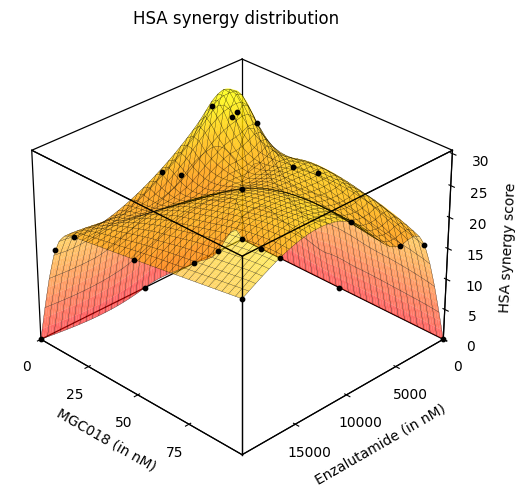

In [6]:


# --- assume Xf, Yf, Zf are your fine grids (possibly interpolated) ---
# Xf, Yf, Zf = ...

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

# -------- shaded surface (no edges) --------
ls = LightSource(azdeg=315, altdeg=45)
rgb = ls.shade(Zf, cmap=cm.autumn, vert_exag=0.5, blend_mode='soft')

alpha = 0.6  # 0 = fully transparent, 1 = opaque

if rgb.shape[-1] == 3:
    # add an alpha channel
    from numpy import ones, concatenate
    a = alpha * np.ones(rgb.shape[:2] + (1,))
    rgba = np.concatenate([rgb, a], axis=-1)
else:  # already RGBA
    rgba = rgb.copy()
    rgba[..., 3] = alpha

ax.plot_surface(
    Xf, Yf, Zf,
    facecolors=rgba,
    rstride=1, cstride=1,
    linewidth=0,
    antialiased=True,
    shade=False,
)

# -------- coarser wire grid on surface only --------
step = 3
ax.plot_wireframe(
    Xf[::step, ::step], Yf[::step, ::step], Zf[::step, ::step],
    color='k', linewidth=0.2
)

# --- axis limits (UPDATED so (0,0,0) is visible) ---
zmin_data = Zf.min()
zmax = Zf.max()
zmin = 0.0                  # force z to start at 0

dz   = zmax - zmin_data
z_offset = zmin_data - 0.2 * dz   # still there if you ever re-enable contours

xmin_data, xmax_data = Xf.min(), Xf.max()
ymin_data, ymax_data = Yf.min(), Yf.max()

xmin = min(xmin_data, 0.0)
xmax = max(xmax_data, 0.0)
ymin = min(ymin_data, 0.0)
ymax = max(ymax_data, 0.0)

ax.set_xlim(xmax, xmin)          # your chosen orientation
ax.set_ylim(ymin, ymax)
ax.set_zlim(zmin, zmax)

# reduce tick crowding / clash at max x,y corner
ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
ax.yaxis.set_major_locator(MaxNLocator(nbins=4))

# drop the very last x and y ticks (removes the overlapping pair)
ax.set_xticks(ax.get_xticks()[:-1])
ax.set_yticks(ax.get_yticks()[:-1])

# -------- bottom contours in xy plane only --------
contours_2D = False
if contours_2D == True:
    ax.contour(
        Xf, Yf, Zf,
        zdir='z', offset=z_offset,
        colors='k', linewidths=0.7
    )

# -------- transparent panes & no built-in grid --------
for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
    axis.set_pane_color((1.0, 1.0, 1.0, 0.0))  # transparent panes
ax.grid(False)

# X, Y, Z = your original data grid, NOT the interpolated Xf, Yf, Zf
ax.scatter(
    X, Y, Z,
    color='k',
    s=10,               # marker size; increase for thicker points
    depthshade=False,   # keeps them solid black
    zorder=11           # draw on top of surface/wire
)

# --- REDRAW ONLY THE FRONT RECTANGLE (y = ymin_box) ON TOP ---
xmax_box, xmin_box = ax.get_xlim3d()
ymin_box, ymax_box = ax.get_ylim3d()
zmin_box, zmax_box = ax.get_zlim3d()

# top and bottom rectangles (z = const)
for z in (zmin_box, zmax_box):
    ax.plot([xmin_box, xmax_box, xmax_box, xmin_box, xmin_box],
            [ymin_box, ymin_box, ymax_box, ymax_box, ymin_box],
            [z,        z,        z,        z,        z],
            color='k', linewidth=0.9)

# vertical edges
for x in (xmin_box, xmax_box):
    for y in (ymin_box, ymax_box):
        ax.plot([x, x], [y, y], [zmin_box, zmax_box],
                color='k', linewidth=0.9)

y_front = ymax_box  # front face is at maximal y in this orientation

# top front edge
ax.plot([xmin_box, xmax_box], [ymax_box, ymax_box],
        [zmax_box, zmax_box], color='k', linewidth=0.9, zorder=10)

# left front vertical edge
ax.plot([xmax_box, xmax_box], [y_front, y_front],
        [zmin_box, zmax_box], color='k', linewidth=0.9, zorder=10)

# right front vertical edge
ax.plot([xmax_box, xmax_box], [ymin_box, ymax_box],
        [zmax_box, zmax_box], color='k', linewidth=0.9, zorder=10)

# -------- labels & view --------
ax.set_xlabel('MGC018 (in nM)')
ax.set_ylabel('Enzalutamide (in nM)', labelpad = 6.5)
ax.set_zlabel('HSA synergy score')  # we'll draw Z label manually so it doesn't get clipped

ax.set_title('HSA synergy distribution',pad=-15)

ax.text2D(
    1.1, 0.5, ' ',           # x > 1.0 puts it a bit outside the axes box
    transform=ax.transAxes,
    rotation=90,
    va='center', ha='left'         # text grows further to the right
)

ax.view_init(elev=30, azim=135)

plt.tight_layout()

plt.savefig("/projects/eshenderov-hpc/Shivang/projects/B7-H3 ADC Manuscript/figures/Fig_7_3D_hsa_synergy_surface.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [7]:
df_bliss = df[['MGC018', 'Enzalutamide', 'HSA.Synergy']].pivot(index='Enzalutamide',columns='MGC018',values='HSA.Synergy')
df_bliss.head()
table = df_bliss

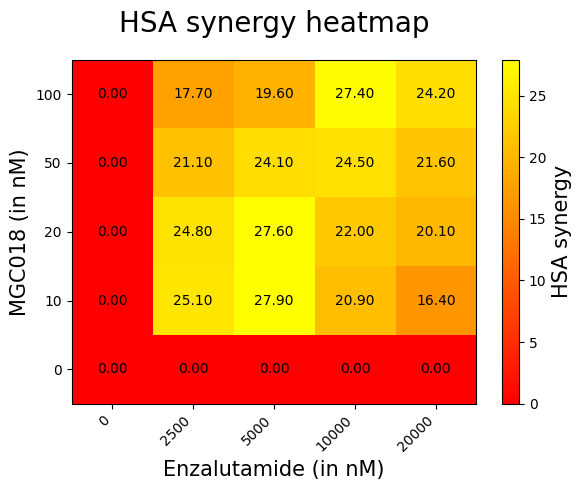

In [8]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

# table: wide DataFrame with index = rows (e.g. y), columns = columns (e.g. x)
# values = z

fig, ax = plt.subplots(figsize=(6, 5))

# use same red→yellow colormap as the 3D plot (autumn)
im = ax.imshow(table.values,
               cmap=cm.autumn,
               aspect='auto',
               origin='lower')   # so first row is at the bottom

# row/column labels
ax.set_xticks(np.arange(table.shape[1]))
ax.set_yticks(np.arange(table.shape[0]))

ax.set_xticklabels(table.columns)
ax.set_yticklabels(table.index)

# axis labels (change text to whatever you want)
ax.set_xlabel('Enzalutamide (in nM)',fontsize=15)
ax.set_ylabel('MGC018 (in nM)',fontsize=15)

# add a title
ax.set_title('HSA synergy heatmap',fontsize=20,pad=20)

# rotate x tick labels if they’re long
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# write values inside each cell
for i in range(table.shape[0]):          # rows (y)
    for j in range(table.shape[1]):      # cols (x)
        ax.text(j, i,
                f"{table.values[i, j]:.2f}",   # format as needed
                ha='center', va='center',
                color='black')

# optional colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('HSA synergy',fontsize=15)

plt.tight_layout()

plt.savefig("/projects/eshenderov-hpc/Shivang/projects/B7-H3 ADC Manuscript/figures/Fig_7_hsa_synergy_heatmap.pdf", format="pdf", bbox_inches="tight")
plt.show()
